In [1]:
%matplotlib inline
from pprint import pprint

from matplotlib import pyplot as plt
import matplotlib

import simulate
from harvesting import N_60_RebalanceHarvesting, N_100_RebalanceHarvesting
import harvesting

import itertools
from decimal import Decimal
from montecarlo import conservative
import metrics
import mortality
import montecarlo
import lens
import pandas
import seaborn
import math
import types
from market import Returns_US_1871
import withdrawal

In [2]:
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [3]:
def is_sequence(arg):
    return (not hasattr(arg, "strip") and
            hasattr(arg, "__iteritems__") or
            hasattr(arg, "__iter__"))

def listify(arg):
    if is_sequence(arg) and not isinstance(arg, dict):
        return arg
    return [arg,]

In [4]:
def make_vpwfloor(floor):
    w = lambda p, h: withdrawal.VPWFloored(p, h, floor=floor)
    w.__name__ = f'VPWFloor_{floor}'
    return w

def run(series, lens, years=30, w1=make_vpwfloor(Decimal('.04')), w2=withdrawal.ConstantDollar):
    (r1, r2) = itertools.tee(series)
    portfolio = (600000, 400000)
    sim1 = simulate.withdrawals(r1, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=w1, portfolio=portfolio)
    sim2 = simulate.withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=w2, portfolio=portfolio)

    df = pandas.DataFrame(data={
        w1.__name__: listify(lens(sim1)),
        w2.__name__: listify(lens(sim2)),
    })
    return df

def run3(series, lens, years=30, w1=make_vpwfloor(Decimal('.04')), w2=withdrawal.ConstantDollar, w3=withdrawal.VPW):
    (r1, r2, r3) = itertools.tee(series, 3)
    portfolio = (600000, 400000)
    sim1 = simulate.withdrawals(r1, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=w1, portfolio=portfolio)
    sim2 = simulate.withdrawals(r2, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=w2, portfolio=portfolio)
    sim3 = simulate.withdrawals(r3, years=years, harvesting=N_60_RebalanceHarvesting, withdraw=w3, portfolio=portfolio)

    df = pandas.DataFrame(data={
        w1.__name__: listify(lens(sim1)),
        w2.__name__: listify(lens(sim2)),
        w3.__name__: listify(lens(sim3)),
    })    
    return df


def withdrawals(s):
    return [int(n.withdraw_r) for n in s]

def portfolio(s):
    return [int(n.portfolio_post.value_r) for n in s]

def cwd(s):
    return [float(n.withdraw_pct_cur) for n in s]

def pv_20(annual):
    portfolio_values = [n.portfolio_post.value_r for n in annual]
    s = pandas.Series(portfolio_values)
    return int(s.at[20])

def wd_20(annual):
    wd = [n.withdraw_pct_cur for n in annual]
    s = pandas.Series(wd)
    return float(s.at[20])

def get_rq(age, withdrawal_pct, stock_pct=60):
    # I can't figure out how to to joint life expectancy so I'll
    # just use female life expectancy for now :/
    life_expectancy = mortality.life_expectancy(None, age)
    mean = montecarlo.simba_mean[stock_pct]
    stddev = montecarlo.simba_stddev[stock_pct]
    
    return metrics.probability_of_ruin(mean, stddev, life_expectancy, float(withdrawal_pct))

def rq(annual):
    r_series = []
    for (i, age) in zip(annual, itertools.count(start=65)):
        r = get_rq(age, i.withdraw_n/i.portfolio_pre.value_n)
        r_series.append(r)
    return r_series

def sustained(annual, floor=Decimal('.04')):
    initial = annual[0].portfolio_pre.value_r
    # subtract $1 to deal with floating point weirdness (sometimes $40 turns into $39.9999)
    floor = floor * initial - 1

    df = pandas.DataFrame(annual)
    failed = df[df['withdraw_r'] < floor]
    s_y = len(failed)

    if s_y:
        return -s_y
    else:
        b_t = df.tail(1)['portfolio_post'].item().value_r
        b_y = b_t / df['withdraw_r'][0]
        return b_y


In [5]:
US = Returns_US_1871()

In [6]:
run(US.iter_from(1969), withdrawals).head()

,VPWFloor_0.04,ConstantDollar
0,49709,40000
1,42090,39999
2,41714,39999
3,44216,40000
4,46700,39999


In [7]:
run(US.iter_from(1969), sustained).head()

,VPWFloor_0.04,ConstantDollar
0,-4,-3


In [8]:
s1 = simulate.calc_lens(N_60_RebalanceHarvesting, make_vpwfloor(Decimal('.04')), 30, sustained)
s2 = simulate.calc_lens(N_60_RebalanceHarvesting, withdrawal.ConstantDollar, 30, sustained)

In [9]:
s1[s1<0]

1906    -2
1962    -3
1964    -3
1965    -5
1966    -6
1967    -2
1968    -5
1969    -4
dtype: object

In [10]:
s2[s2<0]

1965    -2
1966    -4
1968    -3
1969    -3
dtype: object

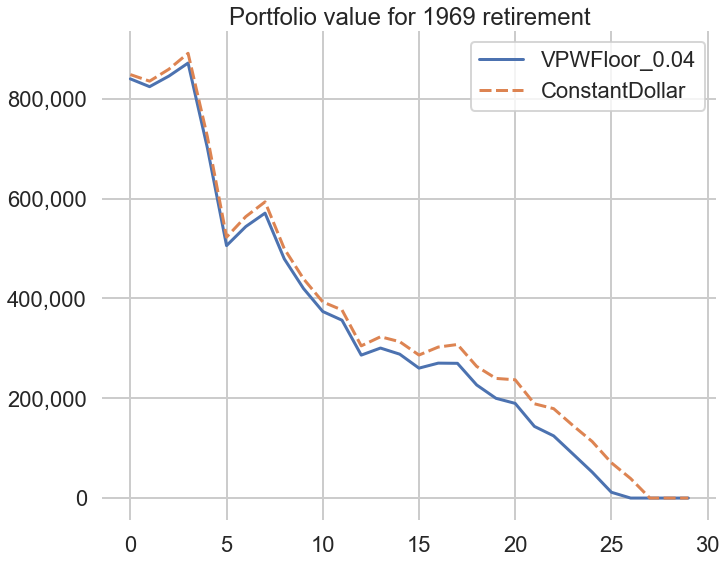

In [11]:
df = run(US.iter_from(1969), portfolio)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Portfolio value for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)
g.axes.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

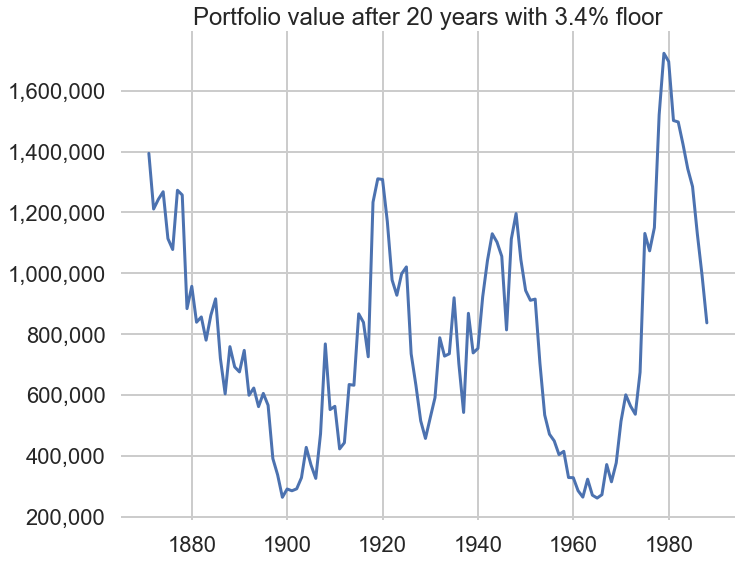

In [12]:
s1 = simulate.calc_lens(N_60_RebalanceHarvesting, make_vpwfloor(Decimal('.034')), 30, pv_20)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=s1)
plt.title('Portfolio value after 20 years with 3.4% floor')
seaborn.despine(left=True, bottom=True, offset=20)
g.axes.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

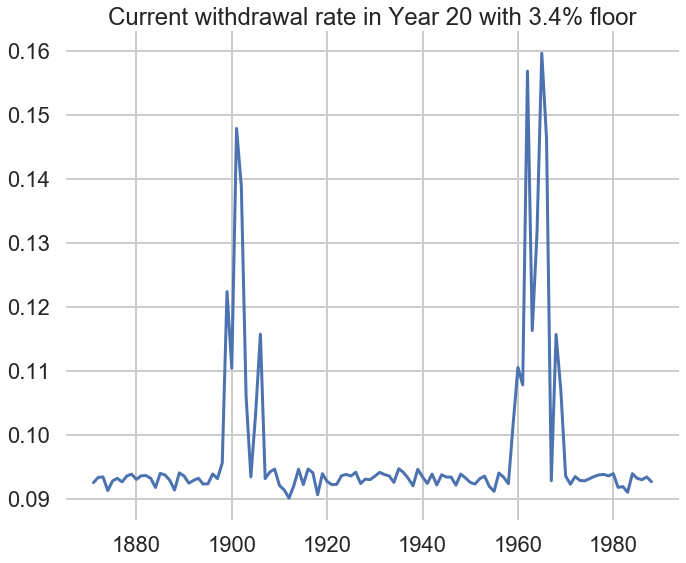

In [13]:
s1 = simulate.calc_lens(N_60_RebalanceHarvesting, make_vpwfloor(Decimal('.034')), 30, wd_20)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=s1)
plt.title('Current withdrawal rate in Year 20 with 3.4% floor')
seaborn.despine(left=True, bottom=True, offset=20)

In [14]:
a = simulate.withdrawals(US.iter_from(1969),
                         years=30,
                         harvesting=N_60_RebalanceHarvesting,
                         withdraw=make_vpwfloor(Decimal('.04')),
                         portfolio=(600_000, 400_000))

In [15]:
sf = []
for i in range(10):
    floor = Decimal('4')
    floor = floor - Decimal(i)/10
    floor = floor / 100
    s1 = simulate.calc_lens(N_60_RebalanceHarvesting, make_vpwfloor(floor), 30, lambda x: sustained(x, floor=floor))
    sf.append((floor, -s1[s1<0].sum()))

0.04     30
0.039    20
0.038    12
0.037     5
0.036     3
0.035     1
0.034     0
0.033     0
0.032     0
0.031     0
dtype: int64

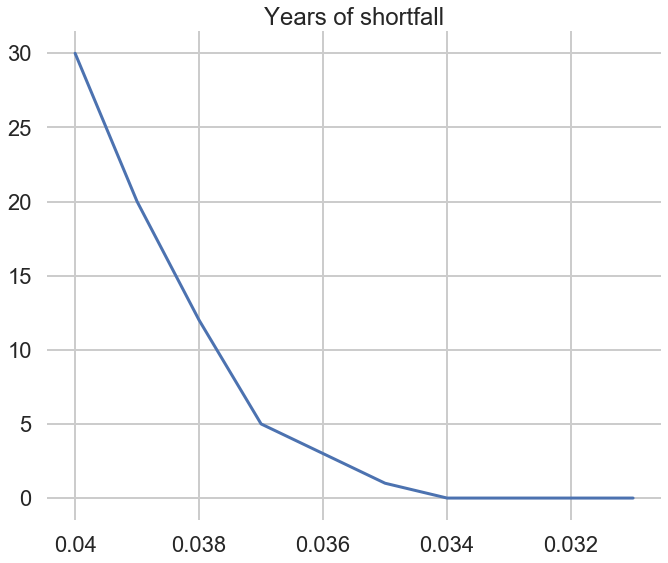

In [16]:
s = pandas.Series(data=[x[1] for x in sf], index=[x[0] for x in sf])
plt.figure(figsize=(11,9))
plt.title('Years of shortfall')
seaborn.despine(left=True, bottom=True, offset=20)
s.plot()
s

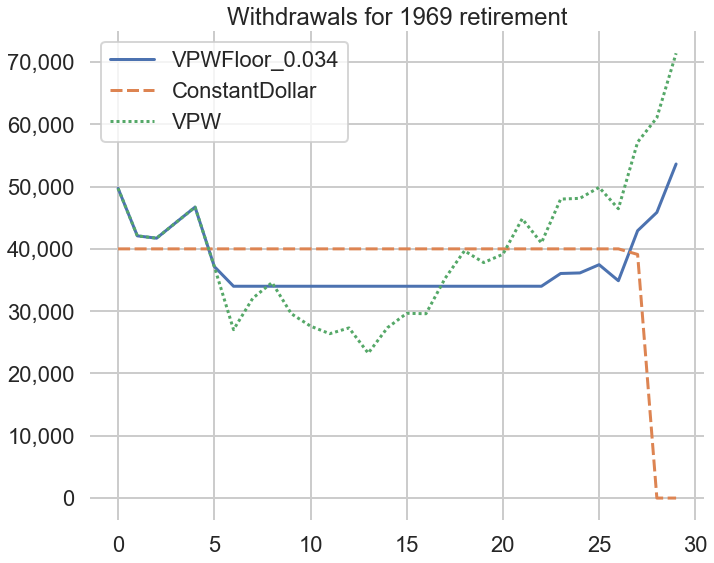

In [17]:
df = run3(US.iter_from(1969), withdrawals, w1=make_vpwfloor(Decimal('0.034')))
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Withdrawals for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)
g.axes.yaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

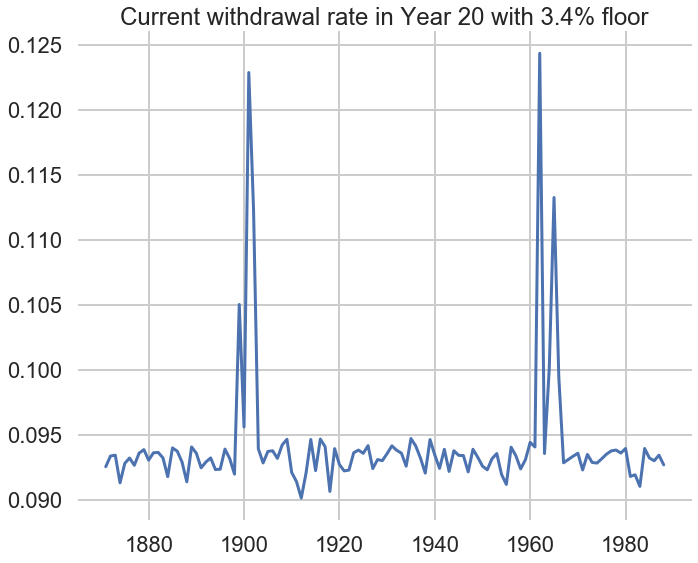

In [18]:
s1 = simulate.calc_lens(N_60_RebalanceHarvesting, make_vpwfloor(Decimal('.03')), 30, wd_20)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=s1)
plt.title('Current withdrawal rate in Year 20 with 3.4% floor')
seaborn.despine(left=True, bottom=True, offset=20)

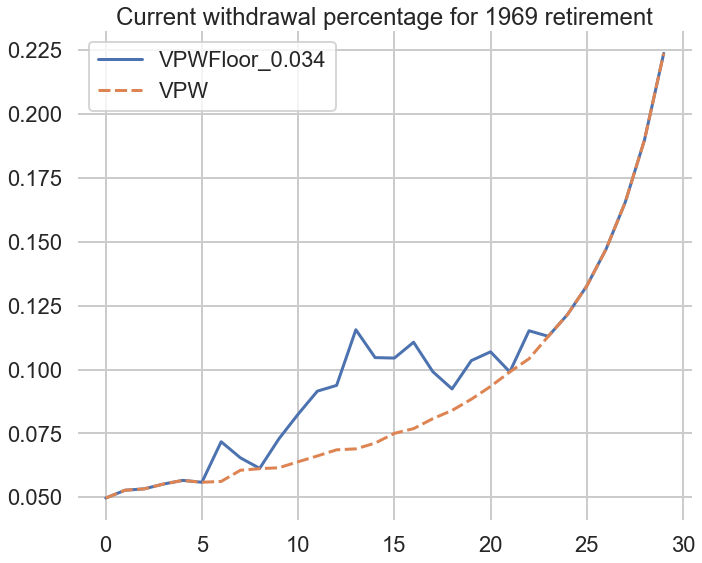

In [19]:
df = run(US.iter_from(1969), cwd, w1=make_vpwfloor(Decimal('0.034')), w2=withdrawal.VPW)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Current withdrawal percentage for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)

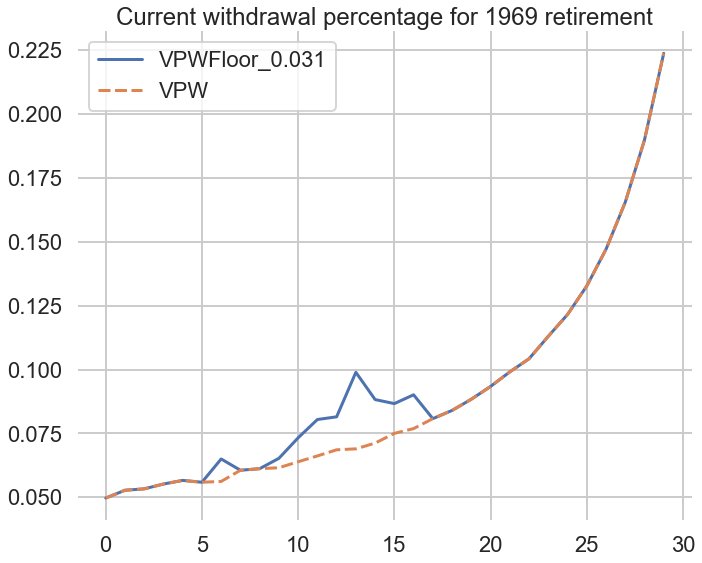

In [20]:
df = run(US.iter_from(1969), cwd, w1=make_vpwfloor(Decimal('0.031')), w2=withdrawal.VPW)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Current withdrawal percentage for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)

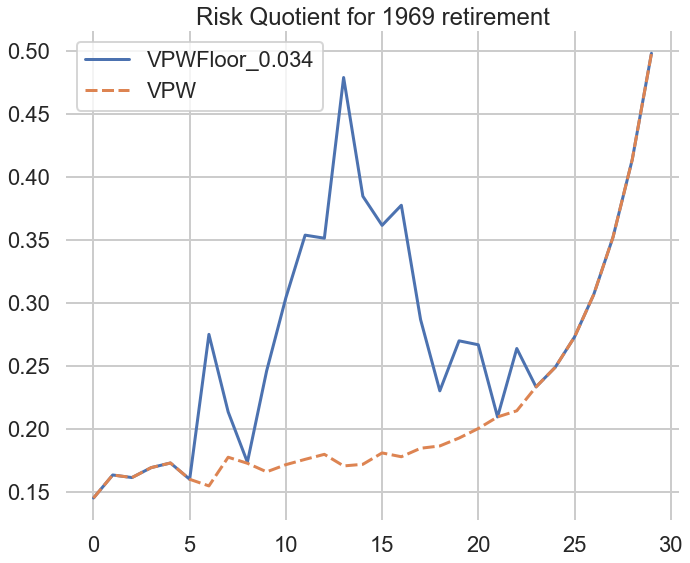

In [21]:
df = run(US.iter_from(1969), rq, w1=make_vpwfloor(Decimal('0.034')), w2=withdrawal.VPW)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Risk Quotient for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)

In [22]:
sf = []
for i in range(15):
    floor = Decimal('3.4')
    floor = floor - Decimal(i)/10
    floor = floor / 100
    df = run(US.iter_from(1969), rq, w1=make_vpwfloor(floor), w2=withdrawal.VPW)
    n = df.iloc[0:20, 0].max()
    sf.append((floor, n))

0.034    0.478920
0.033    0.440109
0.032    0.402320
0.031    0.367227
0.03     0.333741
0.029    0.302354
0.028    0.273215
0.027    0.246720
0.026    0.224860
0.025    0.204494
0.024    0.192850
0.023    0.192848
0.022    0.192848
0.021    0.192848
0.02     0.192848
dtype: float64

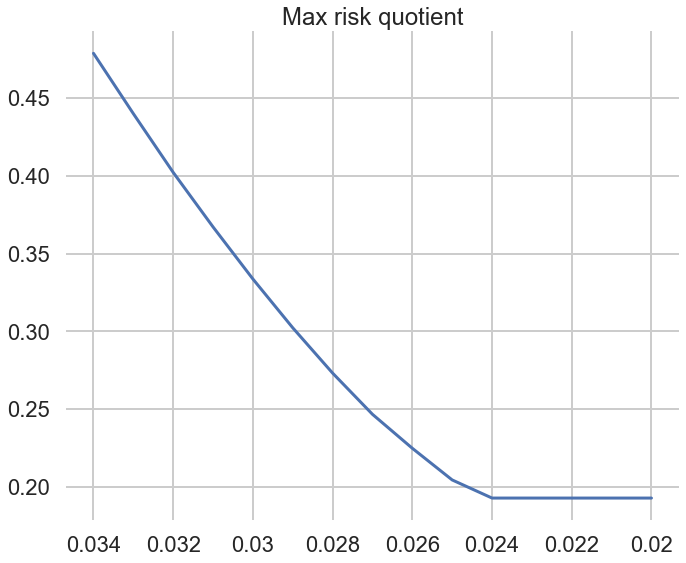

In [23]:
s = pandas.Series(data=[x[1] for x in sf], index=[x[0] for x in sf])
plt.figure(figsize=(11,9))
plt.title('Max risk quotient')
seaborn.despine(left=True, bottom=True, offset=20)
s.plot()
s

0.3337414694815083

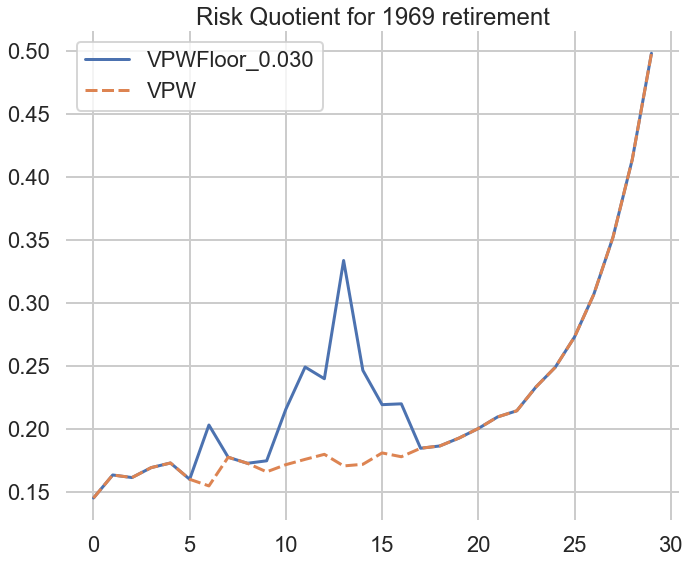

In [24]:
df = run(US.iter_from(1969), rq, w1=make_vpwfloor(Decimal('0.030')), w2=withdrawal.VPW)
plt.figure(figsize=(11,9))
g = seaborn.lineplot(data=df)
plt.title('Risk Quotient for 1969 retirement')
seaborn.despine(left=True, bottom=True, offset=20)
df.iloc[0:20, 0].max()

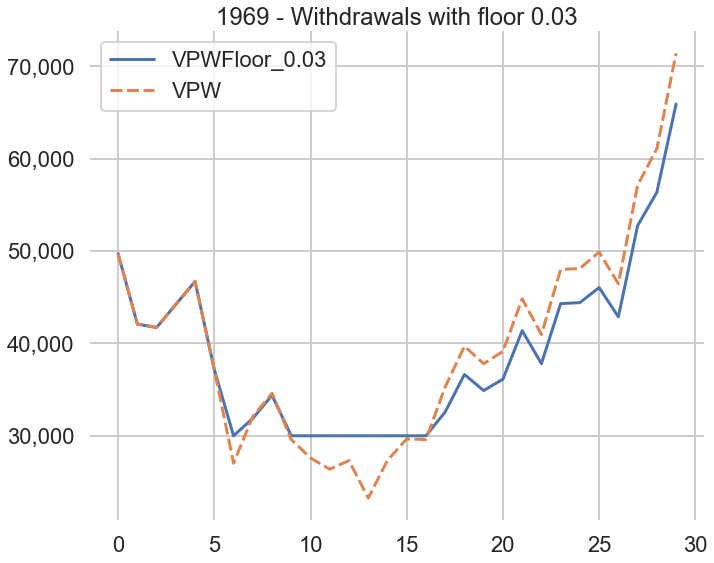

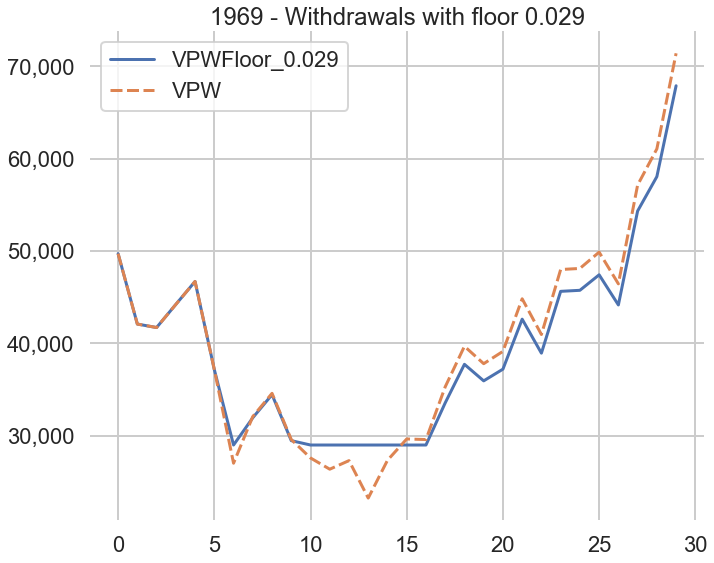

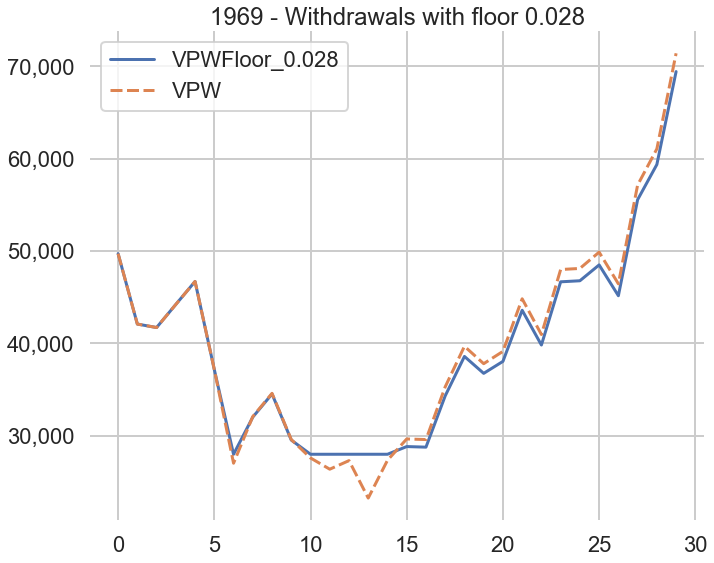

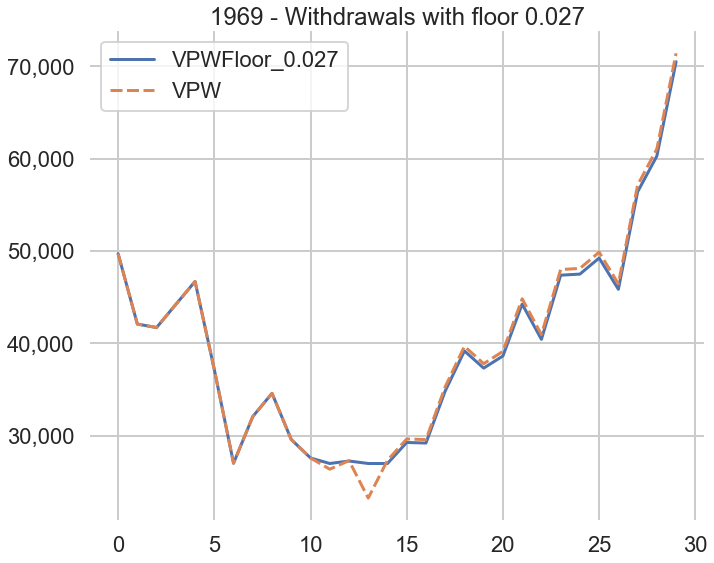

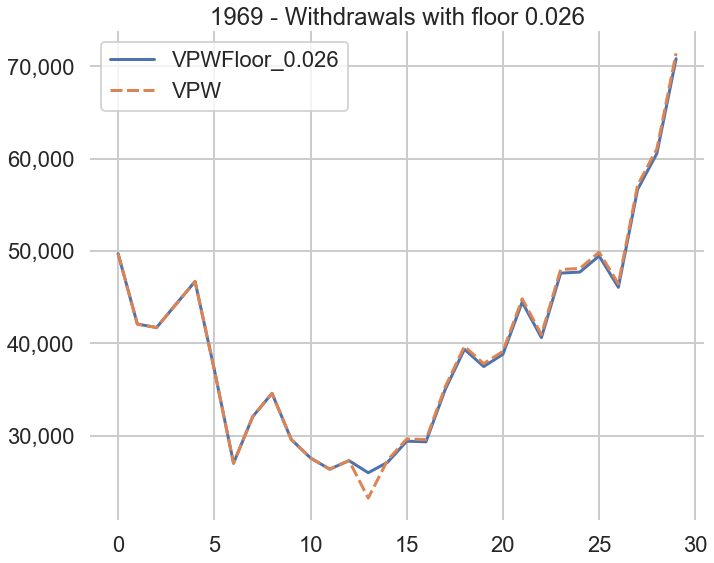

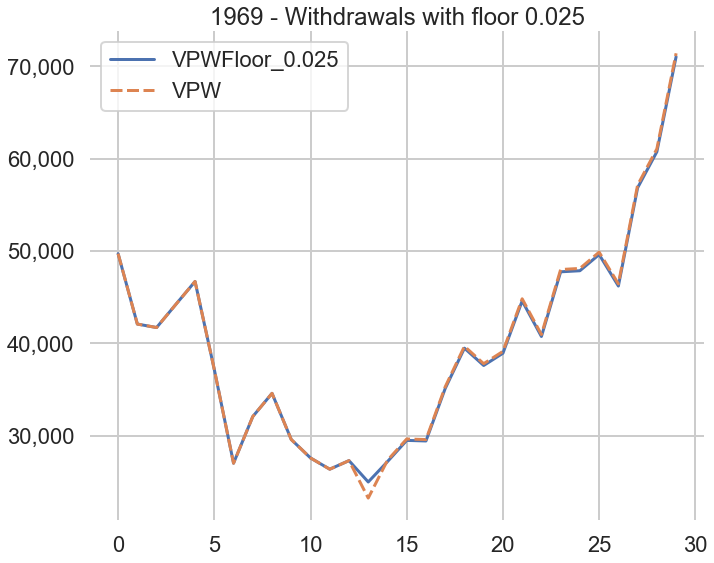

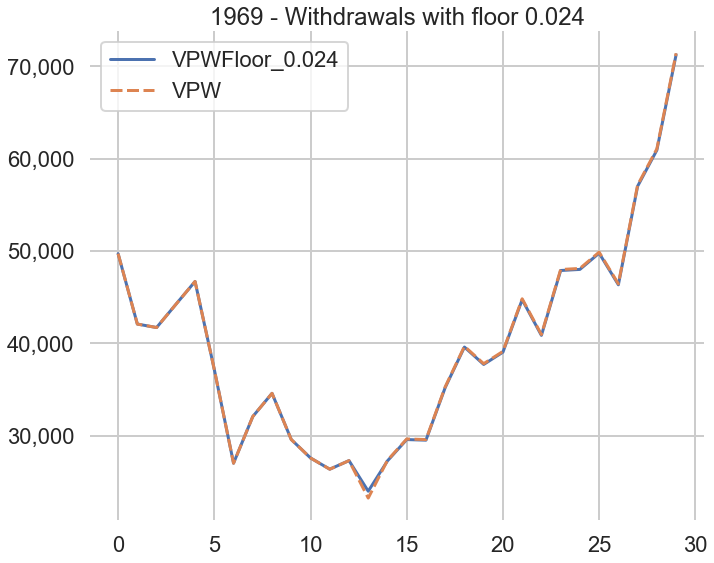

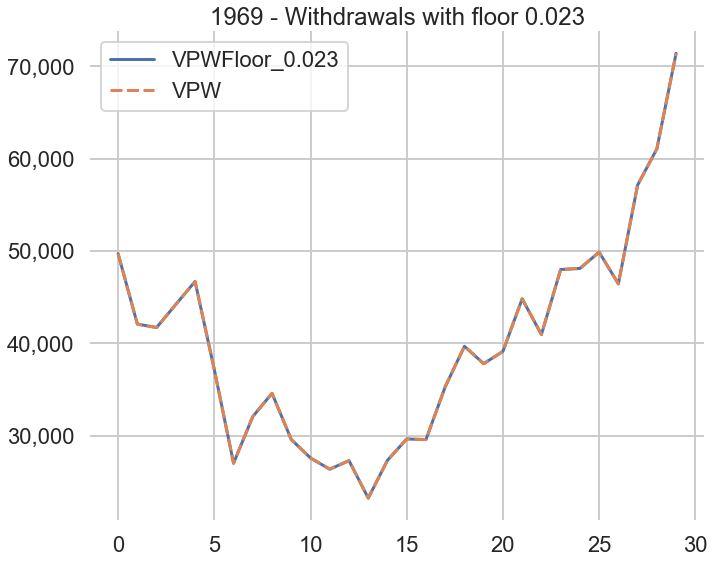

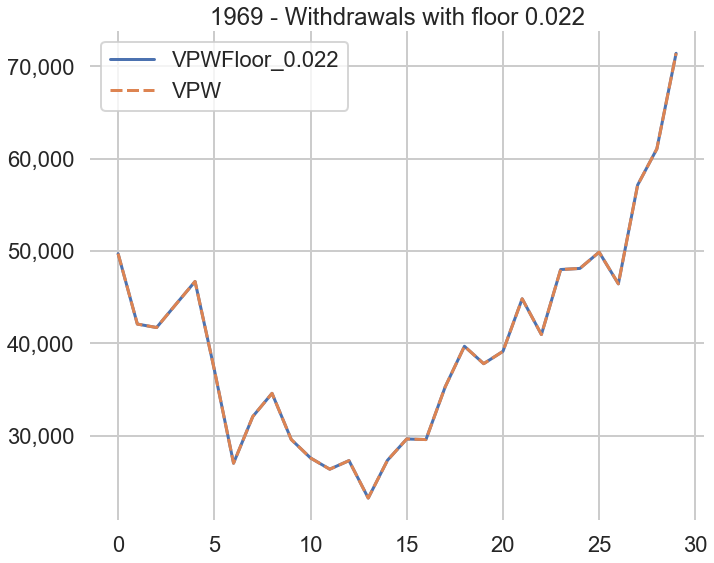

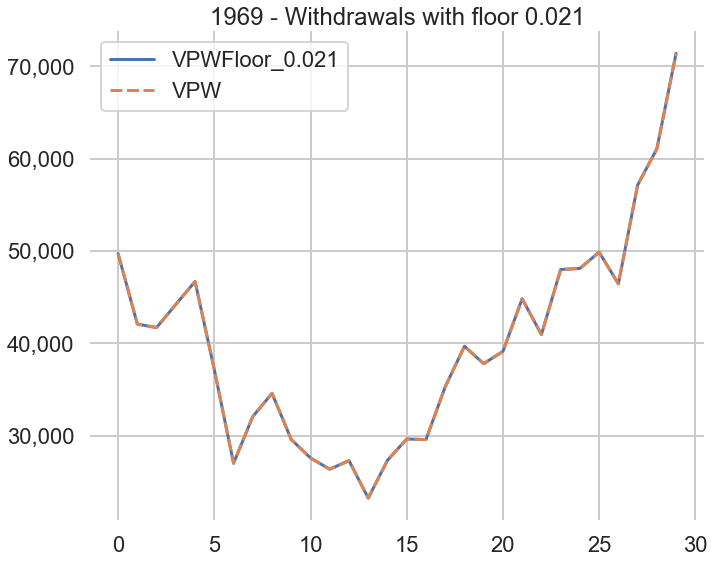

In [33]:
for i in range(10):
    floor = Decimal(3)
    floor = floor - Decimal(i)/10
    floor = floor / 100
    df = run(US.iter_from(1969), withdrawals, w1=make_vpwfloor(floor), w2=withdrawal.VPW)
    plt.figure(figsize=(11,9))
    g = seaborn.lineplot(data=df)
    plt.title(f'1969 - Withdrawals with floor {floor}')
    seaborn.despine(left=True, bottom=True, offset=20)
    g.axes.yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [47]:
df = run(US.iter_from(1969), withdrawals, w1=make_vpwfloor(Decimal('0.030')), w2=withdrawal.VPW)
#new_df = df['VPWFloor_0.028'] - df['VPW']
new_df = df['VPWFloor_0.030'] / df['VPW']
new_df[new_df > 1]

6     1.109841
9     1.013685
10    1.087035
11    1.137058
12    1.098458
13    1.289823
14    1.096976
15    1.011634
16    1.013856
dtype: float64

In [48]:
df

,VPWFloor_0.030,VPW
0,49709,49709
1,42090,42090
2,41714,41714
3,44216,44216
4,46700,46700
5,37167,37167
6,29999,27030
7,31885,32083
8,34380,34593
9,29999,29594
